In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

/home/djjin/anaconda3/envs/conda_visual_HPE/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_May__3_18:49:52_PDT_2022
Cuda compilation tools, release 11.7, V11.7.64
Build cuda_11.7.r11.7/compiler.31294372_0
torch:  1.13 ; cuda:  cu117
detectron2: 0.6


In [2]:
import os
import sys
import logging
import argparse
os.environ["DATASET"] = "../datasets"

pth = '/'.join(sys.path[0].split('/')[:-1])
sys.path.insert(0, pth)

from pprint import pprint
import numpy as np
np.random.seed(1)

home_dir = os.path.abspath(os.getcwd()+"/../")
sys.path.append(home_dir)
print(home_dir)

import warnings
warnings.filterwarnings(action='ignore')
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
from torchvision import transforms
from PIL import Image

from hdecoder.BaseModel import BaseModel
from hdecoder import build_model
from utils.distributed import init_distributed
from utils.arguments import load_opt_from_config_files, load_config_dict_to_opt
from datasets.utils.vcoco_utils import get_random_images, walk_through_dir
from utils.visualizer import draw_hoi_results, plot_obj_attentions

/home/djjin/Mygit/X-Decoder


Invalid MIT-MAGIC-COOKIE-1 key

In [3]:
from utils.arguments import load_vcoco_opt_command, load_vcoco_parser

cmdline_args = load_vcoco_parser()
cmdline_args.conf_files = [os.path.join(home_dir, "configs/hdecoder/vcoco.yaml")]

model_path = '../data/output/test/00089100/default/raw_model_states.pt'
cmdline_args.overrides = ['WEIGHT', 'true', 'RESUME_FROM', model_path] 

opt = load_vcoco_opt_command(cmdline_args)
opt = init_distributed(opt)

In [4]:
pretrained_pth = os.path.join(opt['RESUME_FROM'])
print(pretrained_pth)
output_root = './output'
image_pth = '../images/COCO_val2014_000000565248.jpg'

../data/output/test/00089100/default/raw_model_states.pt


In [5]:
model = BaseModel(opt, build_model(opt)).from_pretrained(pretrained_pth).eval().cuda()

INFO:utils.model:Loaded backbone.layers.0.blocks.0.dw1.bias, Model Shape: torch.Size([96]) <-> Ckpt Shape: torch.Size([96])
INFO:utils.model:Loaded backbone.layers.0.blocks.0.dw1.weight, Model Shape: torch.Size([96, 1, 3, 3]) <-> Ckpt Shape: torch.Size([96, 1, 3, 3])
INFO:utils.model:Loaded backbone.layers.0.blocks.0.dw2.bias, Model Shape: torch.Size([96]) <-> Ckpt Shape: torch.Size([96])
INFO:utils.model:Loaded backbone.layers.0.blocks.0.dw2.weight, Model Shape: torch.Size([96, 1, 3, 3]) <-> Ckpt Shape: torch.Size([96, 1, 3, 3])
INFO:utils.model:Loaded backbone.layers.0.blocks.0.gamma_1, Model Shape: torch.Size([96]) <-> Ckpt Shape: torch.Size([96])
INFO:utils.model:Loaded backbone.layers.0.blocks.0.gamma_2, Model Shape: torch.Size([96]) <-> Ckpt Shape: torch.Size([96])
INFO:utils.model:Loaded backbone.layers.0.blocks.0.mlp.fc1.bias, Model Shape: torch.Size([384]) <-> Ckpt Shape: torch.Size([384])
INFO:utils.model:Loaded backbone.layers.0.blocks.0.mlp.fc1.weight, Model Shape: torch.Si

In [6]:
t = []
t.append(transforms.Resize(800, interpolation=Image.BICUBIC))
transform = transforms.Compose(t)

In [7]:
print(home_dir)
img_root = home_dir + '/datasets/v-coco/images/val2014'
walk_through_dir(img_root)

/home/djjin/Mygit/X-Decoder
There are 0 directories and 40504 images in '/home/djjin/Mygit/X-Decoder/datasets/v-coco/images/val2014'.


In [8]:
image_paths = get_random_images(img_root, nums=1, seed=2)
image_paths

['/home/djjin/Mygit/X-Decoder/datasets/v-coco/images/val2014/COCO_val2014_000000281040.jpg']

Detect 2 HOI!!
<person, stand> (84%)
<person, carry_obj, surfboard> (84%)


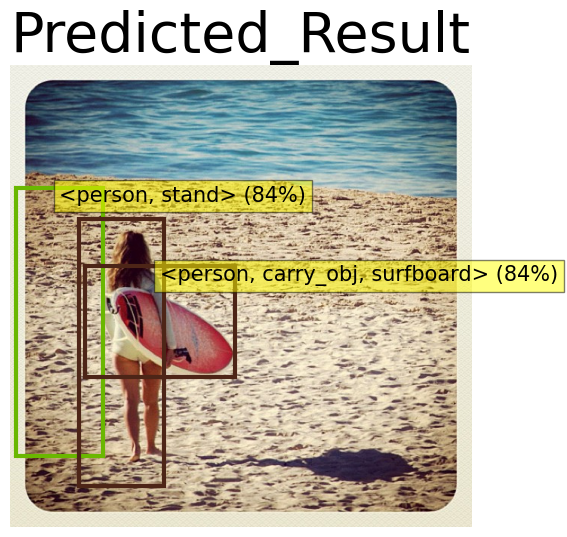

In [9]:
results = []
org_images = []
for image_pth in image_paths:
    image_ori = Image.open(image_pth).convert('RGB')
    
    width = image_ori.size[0]
    height = image_ori.size[1]
    orig_size = (height, width)
    result = model.model.hoi_inference(image_ori, orig_size, transform, thr=0.5)
    results.append(result[-1])
    org_images.append(image_ori)

draw_hoi_results(org_images, results, is_save=False)

In [10]:
model.model.backbone

D2FocalNet(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): BasicLayer(
      (blocks): ModuleList(
        (0): FocalModulationBlock(
          (dw1): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=96)
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (modulation): FocalModulation(
            (f): Linear(in_features=96, out_features=196, bias=True)
            (h): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
            (act): GELU(approximate='none')
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (focal_layers): ModuleList(
              (0): Sequential(
                (0): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), paddin

In [11]:
encoder_self_attn = model.model.hoid_head.encoder.transformer.encoder.layers[-1].self_attn

In [12]:
decoder_multihead_attn = model.model.hoid_head.hoi_decoder.hopd_decoder.layers[-1].multihead_attn

In [16]:
from utils.box_ops import rescale_bboxes
import matplotlib.pyplot as plt
import cv2
from utils.box_ops import rescale_bboxes
from datasets.utils.vcoco_utils import valid_obj_ids, verb_classes, coco_class_list

def plot_obj_attentions(outputs, org_images, orig_target_sizes, conv_features, dec_attn_weights, thr=0.5, cmap='jet'):
    probas = outputs['pred_obj_logits'].softmax(-1)[:, :-1]
    keep = probas.max(-1).values > thr
    obj_scores, obj_labels = probas[..., :-1].max(-1)
    out_bbox = outputs['pred_obj_boxes'][keep]
    if out_bbox.numel() != 0:
        h, w = conv_features['0'].tensors.shape[-2:]
        img_h, img_w = np.asarray(org_images).shape[1], np.asarray(org_images).shape[0]
        # img_h, img_w = (640, 480)
        bboxes_scaled = rescale_bboxes(out_bbox, orig_target_sizes)
        if len(bboxes_scaled) == 1:
            fig, axs = plt.subplots(ncols=len(bboxes_scaled), nrows=1, figsize=(4*len(bboxes_scaled), 5))
            idx = keep.nonzero()
            xmin = bboxes_scaled[0][0]
            ymin = bboxes_scaled[0][1]
            xmax = bboxes_scaled[0][2]
            ymax = bboxes_scaled[0][3]
            ax = axs
            ax.imshow(org_images)
            attention_map = dec_attn_weights[idx].view(h, w).detach().cpu().numpy()
            attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())
            attention_map = cv2.resize(
                attention_map, (img_h, img_w), interpolation=cv2.INTER_CUBIC
            )
            attention_img = ax.imshow(attention_map, alpha=0.3, cmap=cmap)
            ax.axis('off')
            ax.set_title(f'')
            # plt.colorbar(attention_img, ax=ax)

            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color='blue', linewidth=3))
            class_name = coco_class_list[probas[idx].argmax()]
            if class_name is None:
                class_name = "person"
            ax.set_title(f"{class_name}[Q_id: {idx.item()}]")
        else:
            len_image = len(bboxes_scaled)
            if len_image > 4:
                fig, axs = plt.subplots(ncols=4, nrows=(len(bboxes_scaled) + 3) // 4, figsize=(16, 10))
            else:
                fig, axs = plt.subplots(ncols=len_image, nrows=1, figsize=(8 *len(bboxes_scaled), 5))

            for idx, ax_i, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), axs.flatten(), bboxes_scaled):
                ax = ax_i
                ax.imshow(org_images)
                attention_map = dec_attn_weights[idx].view(h, w).detach().cpu().numpy()
                attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())
                attention_map = cv2.resize(
                    attention_map, (img_h, img_w), interpolation=cv2.INTER_CUBIC
                )
                attention_img = ax.imshow(attention_map, alpha=0.7, cmap=cmap)
                ax.axis('off')
                ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                        fill=False, color='blue', linewidth=3))
                ax.axis('off')
                class_name = coco_class_list[probas[idx].argmax()]
                if class_name is None:
                    class_name = "person"
                ax.set_title(f"{class_name}[Q_id: {idx.item()}]")

            for ax in axs.flatten()[len(bboxes_scaled):]:
                ax.axis('off')
            plt.subplots_adjust(wspace=0.2)  # 가로 간격 조절
            plt.subplots_adjust(hspace=0.4)  # 세로 간격 조절
            plt.tight_layout()
        # fig.suptitle("Attention Map", fontsize=20)
        plt.show()


In [17]:

results = []
org_images = []
for image_pth in image_paths:
    image_ori = Image.open(image_pth).convert('RGB')
    
    width = image_ori.size[0]
    height = image_ori.size[1]
    orig_size = (height, width)

    conv_features, enc_attn_weights, dec_attn_weights = [], [], []
    
    hooks = [
        model.model.backbone.register_forward_hook(
            lambda self, input, output: conv_features.append(output)
        ),
        encoder_self_attn.register_forward_hook(
            lambda self, input, output: enc_attn_weights.append(output[1])
        ),
        decoder_multihead_attn.register_forward_hook(
            lambda self, input, output: dec_attn_weights.append(output[1])
        ),
    ]

    result = model.model.hoi_inference(image_ori, orig_size, transform, thr=0.5, return_only_outputs=True)
    
    for hook in hooks:
        hook.remove()


    conv_features = conv_features[0]
    enc_attn_weights = enc_attn_weights[0]
    dec_attn_weights = dec_attn_weights[0]

    print(result)
    
    plot_obj_attentions(result, image_ori, orig_size, conv_features, dec_attn_weights, thr=0.5, cmap='gist_gray')

{'pred_obj_logits': tensor([[[ 0.8273, -8.1209, -8.0420,  ..., -7.8458,  0.0827,  7.3359],
         [ 0.8907, -3.1932, -4.7973,  ..., -4.9315,  3.0125,  7.3846],
         [ 1.2270, -7.8517, -7.4404,  ..., -7.7711,  0.4276,  7.0502],
         ...,
         [ 2.1112, -7.3197, -6.2734,  ..., -6.7965,  2.0468,  7.8317],
         [ 1.2461, -7.8071, -7.2882,  ..., -5.4945,  1.2242,  7.4378],
         [ 1.7382, -7.7943, -5.4799,  ..., -8.6936,  1.9695,  7.1006]]],
       device='cuda:0'), 'pred_verb_logits': tensor([[[-3.4505, -3.0557, -4.2837,  ..., -5.1076, -5.7188, -5.1825],
         [-3.4453, -2.5712, -3.9946,  ..., -5.0706, -6.0394, -4.9122],
         [-3.3167, -2.8985, -4.2140,  ..., -5.0278, -5.6595, -5.0875],
         ...,
         [-3.3824, -2.6036, -4.0069,  ..., -4.8305, -5.6700, -4.9345],
         [-3.5819, -2.9216, -4.2479,  ..., -5.0443, -5.7873, -5.0573],
         [-3.1862, -2.4961, -3.9974,  ..., -4.8179, -5.5358, -4.8892]]],
       device='cuda:0'), 'pred_sub_boxes': tensor([

IndexError: The shape of the mask [1, 99] at index 1 does not match the shape of the indexed tensor [1, 100, 4] at index 1